In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import preprocessing
from sklearn import model_selection

RANDOM_STATE = 2342

%matplotlib inline

In [2]:
train = pd.read_csv('data/train_final.csv', delimiter='\t')
playlists = pd.read_csv('data/playlists_final.csv', delimiter='\t')
target_playlists = pd.read_csv('data/target_playlists.csv', delimiter='\t')
target_tracks = pd.read_csv('data/target_tracks.csv', delimiter = '\t')
tracks = pd.read_csv('data/tracks_final.csv', delimiter='\t')

In [89]:
train, test = model_selection.train_test_split(train, test_size=0.20, random_state=RANDOM_STATE)

In [3]:
playlists.apply(lambda x : len(x['title'].split(',')), axis=1).max()

30

In [4]:
pd.unique(train['playlist_id']).size

45649

In [5]:
pd.unique(train['track_id']).size

99999

In [15]:
playlists.head()

,created_at,playlist_id,title,numtracks,duration,owner
0,1216545588,644838,[12727],27,6522,41504
1,1249326867,7577564,[],9,2650,41504
2,1257766688,3120683,[183],16,3645,44542
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542


In [16]:
train.head()

,playlist_id,track_id
0,3271849,2801526
1,5616275,727878
2,11267488,2805283
3,10103900,1515105
4,3836898,2945623


In [17]:
target_playlists.head()

,playlist_id
0,10024884
1,10624787
2,4891851
3,4267369
4,65078


In [18]:
target_tracks.head()

,track_id
0,1316175
1,3885714
2,3091270
3,226759
4,230596


In [45]:
tracks.head()

,track_id,artist_id,duration,playcount,album,tags
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]"
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]"
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]"
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]"
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]"


In [46]:
tags = set()

In [48]:
for _,row in tracks.iterrows():
    t = [int(x) for x in row['tags'][1:-1].split(',') if x != '']
    for x in t:
        tags.add(x)
        

In [51]:
len(tags)

31900

In [75]:
tags = {}
for _,row in tracks.iterrows():
    t = list(map(lambda x : x.strip(), row['tags'][1:-1].split(',')))
    for x in t:
        if x in tags:
            tags[x].append(row['track_id'])
        else:
            tags[x] = [row['track_id']]
            

In [77]:
tracks.head()

,track_id,artist_id,duration,playcount,album,tags
0,2972914,144,224000,49.0,[7],"[54087, 1757, 1718, 116712, 189631]"
1,2750239,246,157000,1.0,[8],"[189631, 3424, 177424, 46208, 205245]"
2,1550729,144,217000,554.0,[9],"[54087, 109806, 46869, 183258, 54337]"
3,2169950,144,207000,200.0,[9],"[54087, 70618, 207003, 109806, 116712]"
4,1903709,144,198000,5.0,[None],"[54087, 81223, 116712, 215342, 71028]"


In [67]:
album = tracks[(tracks['album'] != '[]') & (tracks['album'] != '[None]')]

In [68]:
album = tracks['album'].apply(lambda x : x[1:-1])

In [70]:
albums = {}
for _,row in tracks.iterrows():
    album = row['album'][1:-1]
    if album != '' and album != 'None':
        if album in albums:
            albums[album].append(row['track_id'])
        else:
            albums[album] = []

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
57531    False
57532    False
57533    False
57534    False
57535    False
57536    False
57537    False
57538    False
57539    False
57540    False
57541    False
57542    False
57543    False
57544    False
57545    False
57546    False
57547    False
57548    False
57549    False
57550    False
57551    False
57552    False
57553    False
57554    False
57555    False
57556    False
57557    False
57558    False
57559    False
57560    False
Name: owner, dtype: bool

In [7]:
density = len(train) / (99999 * 45649)

In [8]:
density

0.00022794199332385227

In [9]:
len(tracks)

100000

In [10]:
len(target_tracks)

32195

In [11]:
s = set(target_tracks['track_id'])

In [12]:
s2 = set(tracks['track_id'])

In [13]:
pl = set(target_playlists['playlist_id'])

In [14]:
pl2 = set(playlists['playlist_id'])

In [47]:
all(x in pl2 for x in pl)

True

In [61]:
playlists['numtrack_token'] = pd.qcut(playlists['numtracks'], 6)

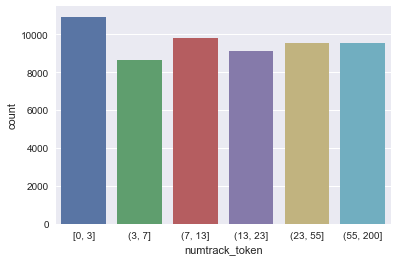

In [62]:
sns.countplot(x = 'numtrack_token', data=playlists)

In [63]:
empty_playlists = playlists[playlists['numtracks'] == 0]

In [64]:
len(empty_playlists)

1173

AttributeError: 'Series' object has no attribute 'val'

In [75]:
p2 = p.groupby('numtrack_token').count()

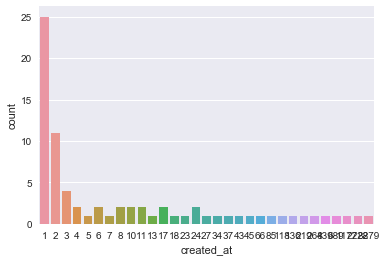

In [76]:
sns.countplot(x='created_at', data=p2)

In [22]:
playlists['created_at_hour'] = pd.cut(playlists['created_at'], 71, labels=[str(i) for i in range(71)])

In [23]:
playlists.head()

,created_at,playlist_id,title,numtracks,duration,owner,created_at_hour
0,1216545588,644838,[12727],27,6522,41504,13
1,1249326867,7577564,[],9,2650,41504,22
2,1257766688,3120683,[183],16,3645,44542,24
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542,21
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542,1


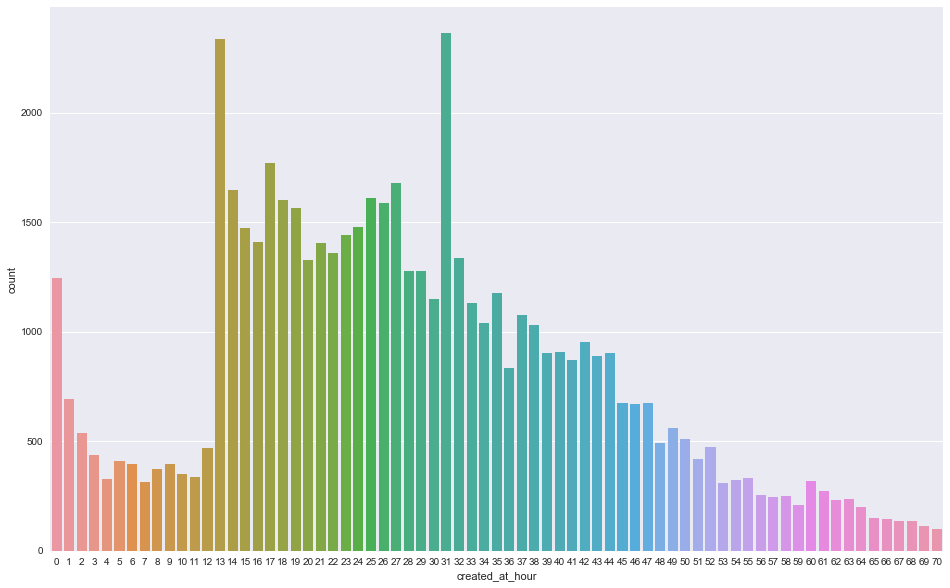

In [27]:
plt.figure(figsize=(16, 10))
sns.countplot(x = 'created_at_hour', data=playlists)

In [86]:
playlists['created_at'].min()

1169657433

In [87]:
playlists['created_at'].max()

1423786569

In [88]:
1423786569 - 1169657433

254129136

In [89]:
254129136 / 1000 / (60 * 60)

70.59142666666666

70 ore

In [134]:
playlists[playlists['playlist_id'] == 34466]

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token


In [136]:
a = train[train['playlist_id'] == 11397138]

In [137]:
b = a['track_id'].values

In [138]:
sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in b])

4577999

In [158]:
def check_playlist(playlist_id):
    duration = int(playlists[playlists['playlist_id'] == playlist_id]['duration'])
    pl_tracks = train[train['playlist_id'] == playlist_id]
    track_ids = pl_tracks['track_id'].values
    
    sum_duration = sum([x['duration'] for _,x in tracks.iterrows() if x['track_id'] in track_ids])
    return sum_duration/1000 <= duration

In [161]:
all(check_playlist(t['playlist_id']) for _,t in playlists.sample(10).iterrows())

True

In [135]:
playlists

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token
0,1216545588,644838,[12727],27,6522,41504,"(23, 55]"
1,1249326867,7577564,[],9,2650,41504,"(7, 13]"
2,1257766688,3120683,[183],16,3645,44542,"(13, 23]"
3,1248079275,4278112,"[12389, 18698, 18925, 11695, 7117]",15,4151,44542,"(13, 23]"
4,1175201268,8656823,"[12809, 2095, 13257, 12671, 20426, 14448, 18698]",84,18414,44542,"(55, 200]"
5,1224952363,10961458,"[7194, 3225, 9438, 13502, 11695]",32,6441,44542,"(23, 55]"
6,1171573001,5527068,[19505],44,13776,40796,"(23, 55]"
7,1220175946,2940714,[12323],69,18214,40796,"(55, 200]"
8,1181710641,11397138,[],27,8466,44467,"(23, 55]"
9,1181710641,3128020,"[12111, 4776, 14448]",89,30451,44467,"(55, 200]"


In [147]:
duration = playlists[playlists['playlist_id'] == 4146222]

In [148]:
duration

,created_at,playlist_id,title,numtracks,duration,owner,numtrack_token
57560,1323724772,4146222,[19676],10,2242,4950,"(7, 13]"


2242

In [79]:
sc.split(train, 2)

[        playlist_id  track_id
 0           3271849   2801526
 1           5616275    727878
 2          11267488   2805283
 3          10103900   1515105
 4           3836898   2945623
 5           5270369   2821391
 6           3794808   1166185
 7           7908370   2498280
 8          11460733    282687
 9            886396    863177
 10          5758965    676462
 11            12268   1896905
 12          3391757   3389845
 13          3738258    351130
 14          4308838   3377520
 15          3296858   3691756
 16         10783548   2288999
 17          6043192     54520
 18          8829360   1818779
 19          8965216   3660211
 20          6839423   3532650
 21         10343825   2226099
 22          8000772   1986571
 23          8323524   2013612
 24          4878824    648387
 25          3631223   3114611
 26          4144882   1081479
 27         10982921    557048
 28          8673728   3050270
 29          8130908    191353
 ...             ...       ...
 520231 

In [80]:
sc.split?